In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import glob
import ROOT

from root_numpy import root2array,fill_profile
from scipy.stats import norm as StatsNorm    # for gaussian fitting
from ROOT import TProfile

Welcome to JupyROOT 6.18/02


/scratch/group/mitchcomp/eb/x86_64/sw/root_numpy/4.8.0-foss-2018b-Python-3.6.6/lib/python3.6/site-packages/root_numpy/__init__.py:46: RuntimeWarning: numpy 1.19.5 is currently installed but you installed root_numpy against numpy 1.15.0. Please consider reinstalling root_numpy for this numpy version.
  RuntimeWarning)


In [2]:
#Predefine the figure size and font size
%matplotlib inline
plt.rcParams['figure.figsize'] = [10.7, 6]
plt.rcParams['font.size']=20
plt.rcParams['axes.labelsize']=16
plt.rcParams['axes.titlesize']=20
plt.rcParams['figure.dpi']=80
plt.rcParams['legend.fontsize']=16

# 0. Data File and Quantities

In [3]:
directory = '/scratch/group/mitchcomp/CDMS/data/nolan/Lei_Samples/CDMSlite_Unifield/samples'
# Particle Hits and DMC outputs (combined)
SuperSim_dir = directory+'/hits/custom/*Sep25*/output'
SuperSimfile = sorted(glob.glob(SuperSim_dir+'/*.root'))
# Raw data (combined)
#RawData_dir = directory + '/raw/custom/*may15*/combined_Binary_files'
#RawDatafile = sorted(glob.glob(RawData_dir+'/*.gz'))
# RQ and RRQ
#RQRRQ_dir = directory + '/processed/custom/*may15*/output/submerged/all/bg'
#RQfile    = sorted(glob.glob(RQRRQ_dir+'/merge*.root'))
#RRQfile   = sorted(glob.glob(RQRRQ_dir+'/calib*.root'))

Geometry0 = root2array(SuperSimfile[0], treename="G4SettingsInfoDir/Geometry")
Geometry0 = Geometry0[0]

In [4]:
#Versions
VersionBranches = root2array(SuperSimfile, treename='G4SettingsInfoDir/Versions')
Versions = pd.DataFrame(VersionBranches)
Versions.iloc[0]

SuperSim                        b'supersim-V09-13-00'
Geant4                  b'geant4-10-06-patch-02 [MT]'
ROOT                                       b'6.18/02'
G4CMP                              b'g4cmp-V08-04-01'
RadSrc                                         b'1.6'
CVODE                                        b'5.1.0'
wimp_sim                         b'wimpsim-V02-00-01'
EPotFiles           b'epotfiles-V00-00-06-0-gf513e20'
SimWorkFlowTools                 b'v5.5.0-0-gf2d9761'
SimProdMacros                 b'V01-08-00-0-ga8b1818'
Name: 0, dtype: object

In [5]:
#SuperSim Macro
f = ROOT.TFile(SuperSimfile[0],'READ')
SuperSim_Macro = f.Get('G4SettingsInfoDir/SuperSim_Macro')
SuperSim_Macro.Print()

/CDMS/Lab NoLab
/CDMS/Detector zip
/CDMS/Zip/MakeHousing
/CDMS/Zip/DetectorConfig CDMSlite1
/CDMS/Physics/DMC
/CDMS/Source contam
/CDMS/Contaminant/bulk
/CDMS/Contaminant/Volume Zip
/CDMS/Contaminant/Generator dmcgun
/CDMS/Contaminant/energy 10 keV
/CDMS/Contaminant/partition
/CDMS/Physics/DMC
/CDMS/Zip/UseLattice
/CDMS/Zip/UseEMField
/CDMS/Zip/TESsubgapAbsorption 0.5
/CDMS/Zip/PhononAbsorption 0.37
/CDMS/Zip/EMField/VoltageOnly true -1
/g4cmp/samplingEnergy 100 eV
/g4cmp/combiningStepLength 2 mm
/CDMS/Physics/DMC
/CDMS/updateGeom
/run/reinitializeGeometry
/run/geometryModified
/CDMS/FETSim/Enable
/CDMS/TESSim/Enable
/CDMS/TESSim/PulseFitter ODE
/CDMS/FETSim/PulseFitter ODE
/CDMS/writeData true
/CDMS/writeTrees true
/CDMS/writeEmptyEvents false
/CDMS/writeEmptyHits false
/CDMS/writeFilePrefix /scratch/group/mitchcomp/CDMS/data/nolan/Lei_Samples/CDMSlite_Unifield/samples/hits/custom/CDMSlite-Bulk-ER10keV-Unifield-Sep25/output/CDMSlite-Bulk-ER10keV-Unifield-Sep25
/CDMS/Physics/ApplyProdu

In [6]:
NumEvts_Gen = root2array(SuperSimfile, treename='G4SettingsInfoDir/runtime', branches='Events')
NumEvts_Pro = root2array(SuperSimfile, treename='G4SimDir/g4dmcEvent',       branches='EventNum')
NumEvts_Gen = int(sum(NumEvts_Gen))
NumEvts_Pro = len(NumEvts_Pro)
print('Number of Generaged Events: {}'.format(NumEvts_Gen))
print('Number of Processed Events: {}'.format(NumEvts_Pro))

Number of Generaged Events: 10000
Number of Processed Events: 10000


In [7]:
# recoil energy: energy deposited in the detector
EvtNumbers  = root2array(SuperSimfile, treename='G4SimDir/g4dmcHits', branches='EventNum')
Edeposit    = root2array(SuperSimfile, treename='G4SimDir/g4dmcHits', branches='trueEnergy')
Erecoil     = Edeposit
# expected phonon energy collected
Y_lindhard  = root2array(SuperSimfile, treename="G4SimDir/g4dmcHits", branches = 'LindhardYield')
PhE_exp     = Erecoil*(1+Y_lindhard*70./2.96)/2. # divided by 2, only one side is read out in CDMSlite)
PhE_exp     = PhE_exp/1e3  # unit: eV->keV
# collected phonon energy in DMC, read out directly from g4dmcEvent
PhE_DMC     = root2array(SuperSimfile, treename='G4SimDir/g4dmcEvent', branches='PhononE')
PhE_DMC     = PhE_DMC/1e3  # unit: eV->keV
# Calculate other further quantities
PhEsum_DMC  = np.array([np.sum(i) for i in PhE_DMC])
CollectEff  = PhEsum_DMC/PhE_exp
PhE_DMC     = np.stack(PhE_DMC, axis=0)  # originally an array of arrays. Convert to a single array

In [8]:
# Positions
PositionX = root2array(SuperSimfile, treename='G4SimDir/g4dmcHits', branches='X')
PositionY = root2array(SuperSimfile, treename='G4SimDir/g4dmcHits', branches='Y')
PositionZ = root2array(SuperSimfile, treename='G4SimDir/g4dmcHits', branches='Z')
X = PositionX*1e3    # unit: m->mm
Y = PositionY*1e3    # unit: m->mm
Z = PositionZ*1e3    # unit: m->mm
R = np.sqrt(X**2+Y**2)

In [9]:
PhE_A   = PhE_DMC[:,0]
PhE_B   = PhE_DMC[:,1]
PhE_C   = PhE_DMC[:,2]
PhE_D   = PhE_DMC[:,3]
PhE_sum = PhEsum_DMC
PhE_BCD = PhE_B+PhE_C+PhE_D

In [10]:
EnergyTotal = 123.24 #keV

# 1. Phonon Energy vs R

In [11]:
cut=CollectEff>=0.98
np.count_nonzero(cut)

9222

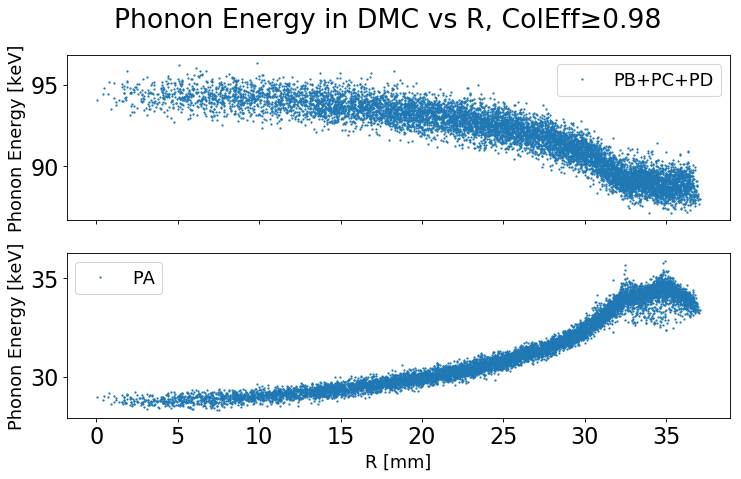

In [12]:
fig, axs = plt.subplots(2, 1, sharex=True)
fig.suptitle('Phonon Energy in DMC vs R, ColEff≥0.98')
axs[0].plot(R[cut], PhE_BCD[cut], '.',markersize=2,label='PB+PC+PD')
#axs[0].plot(R[~cut],PhE_BCD[~cut],'.',markersize=2,label='PB+PC+PD'+', ColEff<0.98')
axs[0].legend()
axs[1].plot(R[cut], PhE_A[cut], '.',markersize=2,label='PA')
#axs[1].plot(R[~cut],PhE_A[~cut],'.',markersize=2,label='PA'+', ColEff<0.98')
axs[1].legend()

for ax in axs.flat:
    ax.set(xlabel='R [mm]',ylabel='Phonon Energy [keV]')
    ax.label_outer()   
    
plt.show()

# 2. Two Circle Model and its Prediction

## 2.1 One Circle for Fast Component

In [13]:
r1 = 15
R1 = 31.3
R2 = 36.1
R3 = 38.1

step = 0.1
d    = np.linspace(0,R3,int(R3/step))

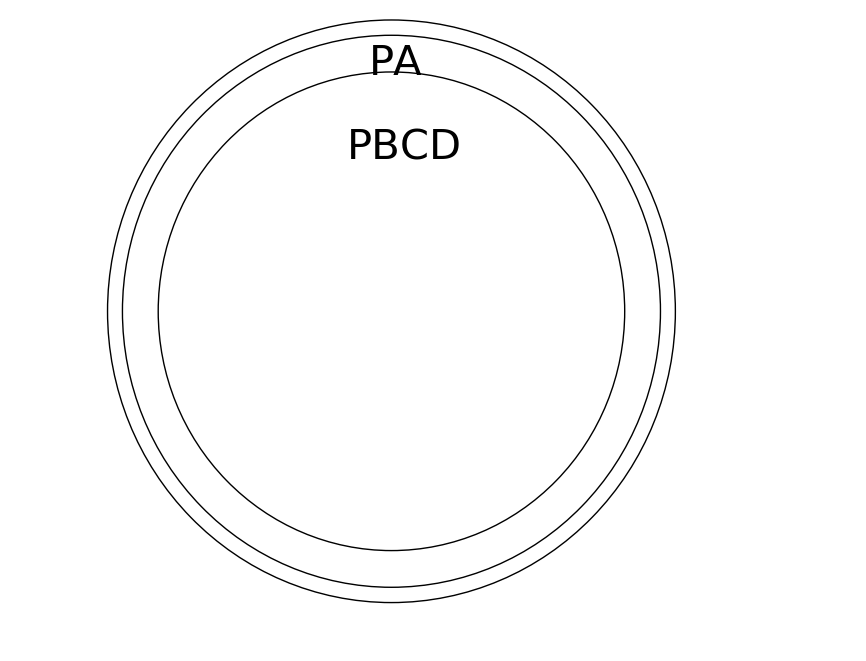

In [14]:
plt.figure(figsize=(10, 8), dpi=100)
Rh = 30
circle_Det   = plt.Circle(( 0, 0), R3, edgecolor='k',fill=False)
circle_PA    = plt.Circle(( 0, 0), R2, edgecolor='k',fill=False)
circle_PBCD  = plt.Circle(( 0, 0), R1, edgecolor='k',fill=False)

plt.gca().add_patch(circle_Det)
plt.gca().add_patch(circle_PA)
plt.gca().add_patch(circle_PBCD)

plt.text(-3, 31,'PA', fontsize='30')
#plt.text( -1,  31, 'A', size='xx-large')
plt.text(-6, 20,'PBCD', fontsize='30')


plt.xlim(-40-2,40+20+2)
plt.ylim(-40+0.5,40-0.5)
plt.axis('off')
plt.show()

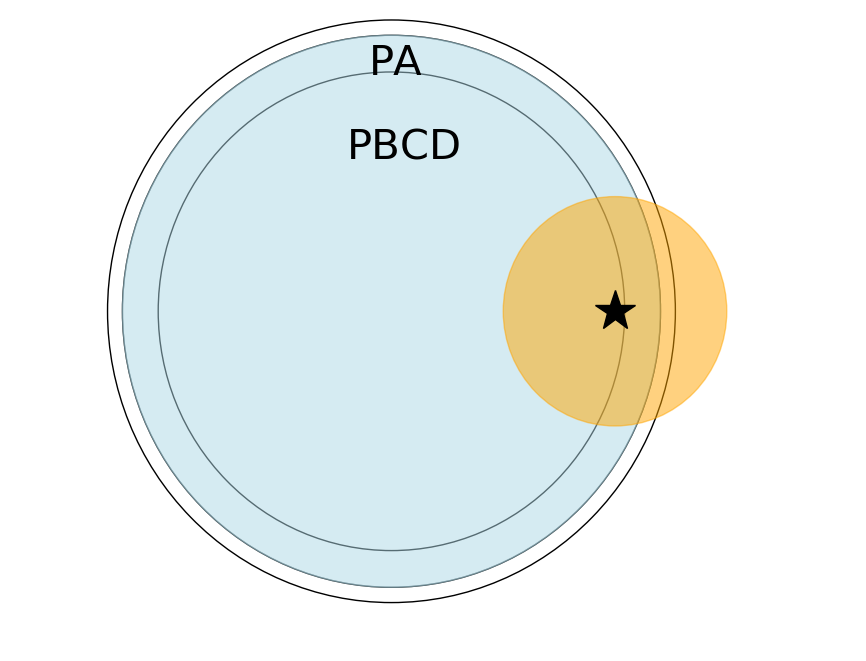

In [15]:
plt.figure(figsize=(10, 8), dpi=100)
Rh = 30
circle_Det   = plt.Circle(( 0, 0), R3, edgecolor='k',fill=False)
circle_PA    = plt.Circle(( 0, 0), R2, edgecolor='k',fill=False)
circle_PBCD  = plt.Circle(( 0, 0), R1, edgecolor='k',fill=False)
circle_slow  = plt.Circle(( 0, 0), R2, color='lightblue', alpha=0.5)
circle_fast1 = plt.Circle((Rh, 0), r1, color='orange', alpha=0.5)
#circle_fast2 = plt.Circle((Rh, 0), r2, color='orange', alpha=0.5)
#circle_fast3 = plt.Circle((Rh, 0), r3, color='orange', alpha=0.5)
plt.plot(Rh, 0,'*',color='k',markersize=30)
plt.gca().add_patch(circle_Det)
plt.gca().add_patch(circle_PA)
plt.gca().add_patch(circle_PBCD)
plt.gca().add_patch(circle_slow)
plt.gca().add_patch(circle_fast1)
#plt.gca().add_patch(circle_fast2)
#plt.gca().add_patch(circle_fast3)

plt.text(-3, 31,'PA', fontsize='30')
#plt.text( -1,  31, 'A', size='xx-large')
plt.text(-6, 20,'PBCD', fontsize='30')


plt.xlim(-40-2,40+20+2)
plt.ylim(-40+0.5,40-0.5)
plt.axis('off')
plt.show()

In [16]:
pi = np.pi
Area_r1 = pi*r1**2
#Area_r2 = pi*r2**2
#Area_r3 = pi*r3**2
Area_R1 = pi*R1**2
Area_R2 = pi*R2**2
Area_R3 = pi*R3**2

In [17]:
Area_PT   = pi*R2**2
Area_PA   = pi*R2**2-pi*R1**2
Area_PBCD = pi*R1**2

In [18]:
Area_slowPBCD  = Area_PBCD
Area_slowPA    = Area_PA
Ratio_slowPBCD = Area_PBCD/Area_PT
Ratio_slowPA   = Area_PA/Area_PT

In [19]:
EnergyfastRatio1 = 6.00/100
#EnergyfastRatio2 = 3.00/100
#EnergyfastRatio3 = 2.00/100
EnergyslowRatio  = 1-EnergyfastRatio1

### 2.1.1 Fraction of Phonon Energy BCD

In [20]:
step = 0.1
## overlap r1R1
d1    = np.linspace(R1-r1+step,R3,int((R3-R1+r1)/step))
term1 = (r1**2)*np.arccos((d1**2+r1**2-R1**2)/(2*d1*r1))
term2 = (R1**2)*np.arccos((d1**2-r1**2+R1**2)/(2*d1*R1))
term3 = -0.5*np.sqrt((d1+r1-R1)*(d1-r1+R1)*(-d1+r1+R1)*(d1+r1+R1))
Area_overlap_r1R1  = term1+term2+term3
Area_lune_r1R1     = Area_r1-Area_overlap_r1R1
Ratio_overlap_r1R1 = Area_overlap_r1R1/Area_r1
Ratio_lune_r1R1    = 1-Ratio_overlap_r1R1
Ratio_r1inBCD = np.concatenate((np.ones(len(d)-len(d1)),Ratio_overlap_r1R1),axis=None)

In [21]:
Energy_BCD = EnergyTotal*( EnergyfastRatio1*Ratio_r1inBCD
                          +EnergyslowRatio*Ratio_slowPBCD)

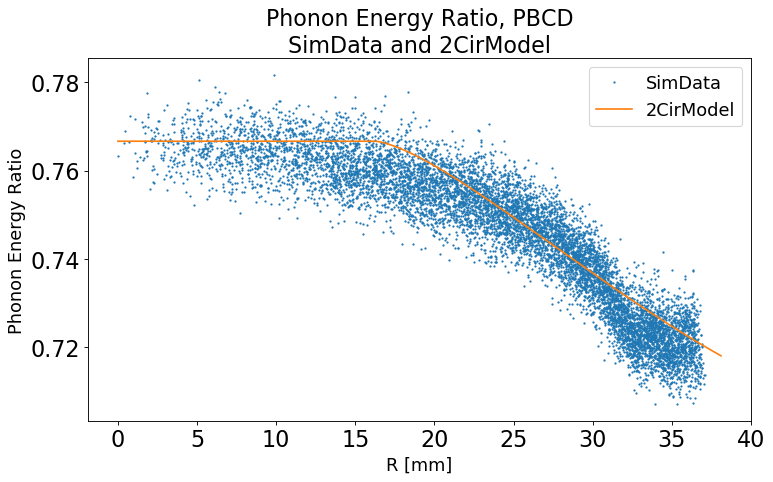

In [22]:
plt.plot(R[cut], PhE_BCD[cut]/EnergyTotal, '.',markersize=2,label='SimData')
plt.plot(d,Energy_BCD/EnergyTotal,label='2CirModel')

plt.title('Phonon Energy Ratio, PBCD'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('Phonon Energy Ratio')
plt.legend()
plt.show()

### 2.1.2 Fraction of Phonon Energy A

In [24]:
step = 0.1
## overlap r1R2
d1    = np.linspace(R2-r1+step,R3,int((R3-R2+r1)/step))
term1 = (r1**2)*np.arccos((d1**2+r1**2-R2**2)/(2*d1*r1))
term2 = (R2**2)*np.arccos((d1**2-r1**2+R2**2)/(2*d1*R2))
term3 = -0.5*np.sqrt((d1+r1-R2)*(d1-r1+R2)*(-d1+r1+R2)*(d1+r1+R2))
Area_overlap_r1R2  = term1+term2+term3
Area_lune_r1R2     = Area_r1-Area_overlap_r1R2
Ratio_overlap_r1R2 = Area_overlap_r1R2/Area_r1
Ratio_lune_r1R2    = 1-Ratio_overlap_r1R2
Ratio_r1inA = 1-Ratio_r1inBCD#-np.concatenate((np.zeros(len(d)-len(d1)),Ratio_lune_r1R2),axis=None)

In [25]:
Energy_A = EnergyTotal*( EnergyfastRatio1*Ratio_r1inA
                        +EnergyslowRatio*Ratio_slowPA)

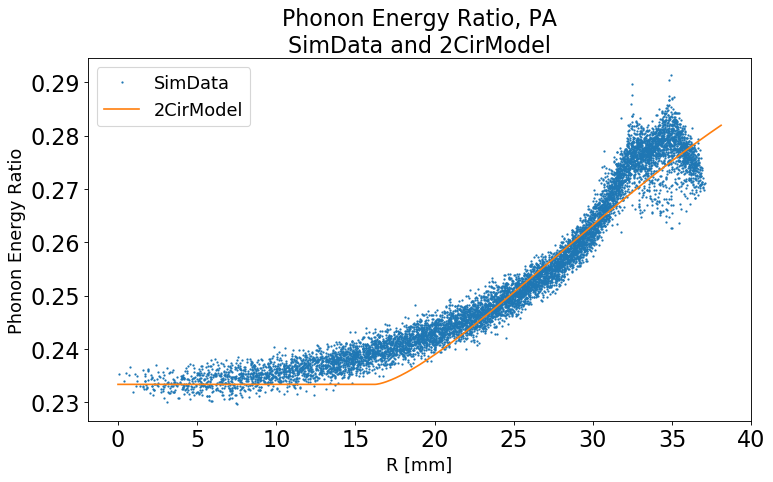

In [26]:
plt.plot(R[cut], PhE_A[cut]/EnergyTotal, '.',markersize=2,label='SimData')
plt.plot(d,Energy_A/EnergyTotal,label='2CirModel')

plt.title('Phonon Energy Ratio, PA'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('Phonon Energy Ratio')
plt.legend()
plt.show()

### 2.2.3 Phonon Energy A2BCD

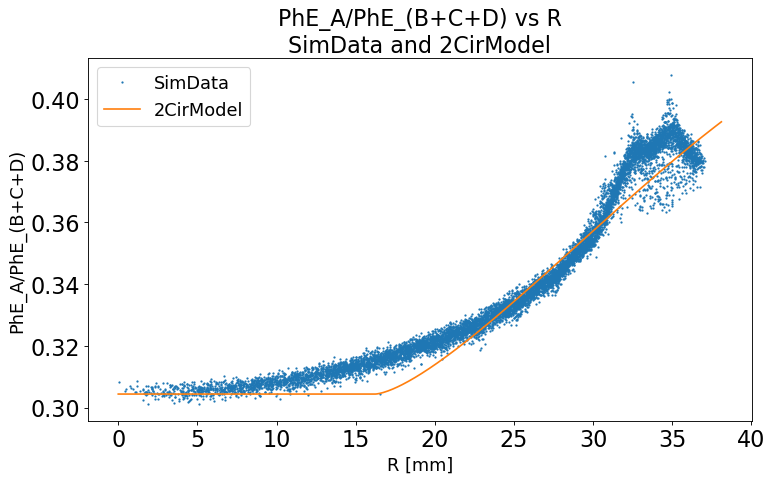

In [27]:
PhE_A2BCD = PhE_A/PhE_BCD
plt.plot(R[cut], PhE_A2BCD[cut], '.',markersize=2,label='SimData')
plt.plot(d,Energy_A/Energy_BCD,label='2CirModel')
#plt.plot(R[~cut],PhE_A2BCD[~cut],'.',label='ColEff<0.98')
#plt.hlines(0.35,0,38.1,linestyles='dashed',colors='g',lw=2,label='A/BCD=0.35')
plt.title('PhE_A/PhE_(B+C+D) vs R'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('PhE_A/PhE_(B+C+D)')
plt.legend()
plt.show()

## 2.2 Two Circles for Fast Component

In [28]:
r1 = 7
r2 = 15
#r3 = 25
R1 = 31.3
R2 = 36.1
R3 = 38.1

step = 0.1
d    = np.linspace(0,R3,int(R3/step))

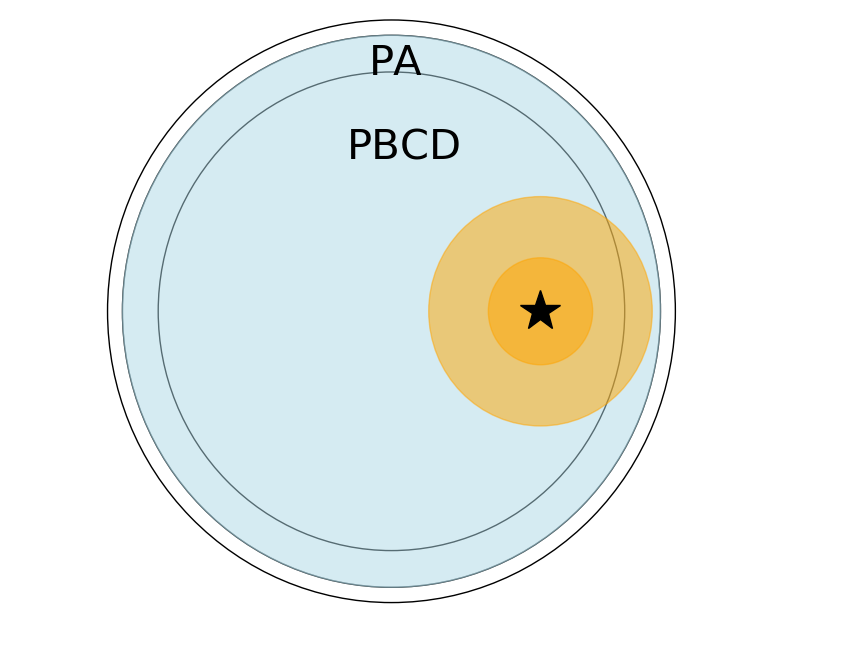

In [29]:
plt.figure(figsize=(10, 8), dpi=100)
Rh = 20
circle_Det   = plt.Circle(( 0, 0), R3, edgecolor='k',fill=False)
circle_PA    = plt.Circle(( 0, 0), R2, edgecolor='k',fill=False)
circle_PBCD  = plt.Circle(( 0, 0), R1, edgecolor='k',fill=False)
circle_slow  = plt.Circle(( 0, 0), R2, color='lightblue', alpha=0.5)
circle_fast1 = plt.Circle((Rh, 0), r1, color='orange', alpha=0.5)
circle_fast2 = plt.Circle((Rh, 0), r2, color='orange', alpha=0.5)
#circle_fast3 = plt.Circle((Rh, 0), r3, color='orange', alpha=0.5)
plt.plot(Rh, 0,'*',color='k',markersize=30)
plt.gca().add_patch(circle_Det)
plt.gca().add_patch(circle_PA)
plt.gca().add_patch(circle_PBCD)
plt.gca().add_patch(circle_slow)
plt.gca().add_patch(circle_fast1)
plt.gca().add_patch(circle_fast2)
#plt.gca().add_patch(circle_fast3)

plt.text(-3, 31,'PA', fontsize='30')
#plt.text( -1,  31, 'A', size='xx-large')
plt.text(-6, 20,'PBCD', fontsize='30')


plt.xlim(-40-2,40+20+2)
plt.ylim(-40+0.5,40-0.5)
plt.axis('off')
plt.show()

In [30]:
EnergyfastRatio1 = 3.00/100
EnergyfastRatio2 = 3.00/100
#EnergyfastRatio3 = 2.00/100
EnergyslowRatio  = 1-EnergyfastRatio1-EnergyfastRatio2

In [31]:
pi = np.pi
Area_r1 = pi*r1**2
Area_r2 = pi*r2**2
#Area_r3 = pi*r3**2
Area_R1 = pi*R1**2
Area_R2 = pi*R2**2
Area_R3 = pi*R3**2

In [32]:
Area_PT   = pi*R2**2
Area_PA   = pi*R2**2-pi*R1**2
Area_PBCD = pi*R1**2

In [33]:
Area_slowPBCD  = Area_PBCD
Area_slowPA    = Area_PA
Ratio_slowPBCD = Area_PBCD/Area_PT
Ratio_slowPA   = Area_PA/Area_PT

### 2.2.1 Fraction of Phonon Energy BCD

In [34]:
step = 0.1
## overlap r1R1
d1    = np.linspace(R1-r1+step,R3,int((R3-R1+r1)/step))
term1 = (r1**2)*np.arccos((d1**2+r1**2-R1**2)/(2*d1*r1))
term2 = (R1**2)*np.arccos((d1**2-r1**2+R1**2)/(2*d1*R1))
term3 = -0.5*np.sqrt((d1+r1-R1)*(d1-r1+R1)*(-d1+r1+R1)*(d1+r1+R1))
Area_overlap_r1R1  = term1+term2+term3
Area_lune_r1R1     = Area_r1-Area_overlap_r1R1
Ratio_overlap_r1R1 = Area_overlap_r1R1/Area_r1
Ratio_lune_r1R1    = 1-Ratio_overlap_r1R1
Ratio_r1inBCD = np.concatenate((np.ones(len(d)-len(d1)),Ratio_overlap_r1R1),axis=None)

In [35]:
## overlap r2R1
d2    = np.linspace(R1-r2+step,R3,int((R3-R1+r2)/step))
term1 = (r2**2)*np.arccos((d2**2+r2**2-R1**2)/(2*d2*r2))
term2 = (R1**2)*np.arccos((d2**2-r2**2+R1**2)/(2*d2*R1))
term3 = -0.5*np.sqrt((d2+r2-R1)*(d2-r2+R1)*(-d2+r2+R1)*(d2+r2+R1))
Area_overlap_r2R1  = term1+term2+term3
Area_lune_r2R1     = Area_r2-Area_overlap_r2R1
Ratio_overlap_r2R1 = Area_overlap_r2R1/Area_r2
Ratio_lune_r2R1    = 1-Ratio_overlap_r2R1
Ratio_r2inBCD = np.concatenate((np.ones(len(d)-len(d2)),Ratio_overlap_r2R1),axis=None)

In [36]:
Energy_BCD = EnergyTotal*( EnergyfastRatio1*Ratio_r1inBCD
                          +EnergyfastRatio2*Ratio_r2inBCD
                          +EnergyslowRatio*Ratio_slowPBCD)

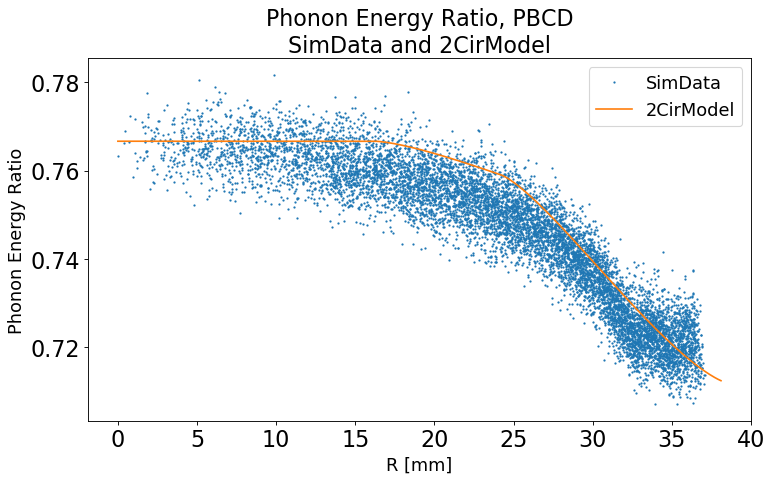

In [37]:
plt.plot(R[cut], PhE_BCD[cut]/EnergyTotal, '.',markersize=2,label='SimData')
plt.plot(d,Energy_BCD/EnergyTotal,label='2CirModel')

plt.title('Phonon Energy Ratio, PBCD'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('Phonon Energy Ratio')
plt.legend()
plt.show()

### 2.2.2 Fraction of Phonon Energy A

In [38]:
step = 0.1
## overlap r1R2
d1    = np.linspace(R2-r1+step,R3,int((R3-R2+r1)/step))
term1 = (r1**2)*np.arccos((d1**2+r1**2-R2**2)/(2*d1*r1))
term2 = (R2**2)*np.arccos((d1**2-r1**2+R2**2)/(2*d1*R2))
term3 = -0.5*np.sqrt((d1+r1-R2)*(d1-r1+R2)*(-d1+r1+R2)*(d1+r1+R2))
Area_overlap_r1R2  = term1+term2+term3
Area_lune_r1R2     = Area_r1-Area_overlap_r1R2
Ratio_overlap_r1R2 = Area_overlap_r1R2/Area_r1
Ratio_lune_r1R2    = 1-Ratio_overlap_r1R2
Ratio_r1inA = 1-Ratio_r1inBCD#-np.concatenate((np.zeros(len(d)-len(d1)),Ratio_lune_r1R2),axis=None)

In [39]:
step = 0.1
## overlap r2R2
d2    = np.linspace(R2-r2+step,R3,int((R3-R2+r2)/step))
term1 = (r2**2)*np.arccos((d2**2+r2**2-R2**2)/(2*d2*r2))
term2 = (R2**2)*np.arccos((d2**2-r2**2+R2**2)/(2*d2*R2))
term3 = -0.5*np.sqrt((d2+r2-R2)*(d2-r2+R2)*(-d2+r2+R2)*(d2+r2+R2))
Area_overlap_r2R2  = term1+term2+term3
Area_lune_r2R2     = Area_r2-Area_overlap_r2R2
Ratio_overlap_r2R2 = Area_overlap_r2R2/Area_r2
Ratio_lune_r2R2    = 1-Ratio_overlap_r2R2
Ratio_r2inA = 1-Ratio_r2inBCD#-np.concatenate((np.zeros(len(d)-len(d2)),Ratio_lune_r2R2),axis=None)

In [40]:
Energy_A = EnergyTotal*( EnergyfastRatio1*Ratio_r1inA
                        +EnergyfastRatio2*Ratio_r2inA
                        +EnergyslowRatio*Ratio_slowPA)

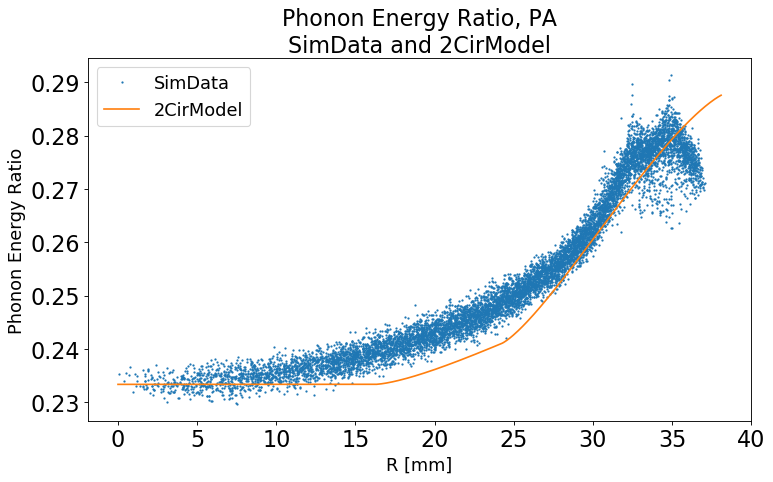

In [41]:
plt.plot(R[cut], PhE_A[cut]/EnergyTotal, '.',markersize=2,label='SimData')
plt.plot(d,Energy_A/EnergyTotal,label='2CirModel')

plt.title('Phonon Energy Ratio, PA'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('Phonon Energy Ratio')
plt.legend()
plt.show()

### 2.2.3 Phonon Energy A2BCD

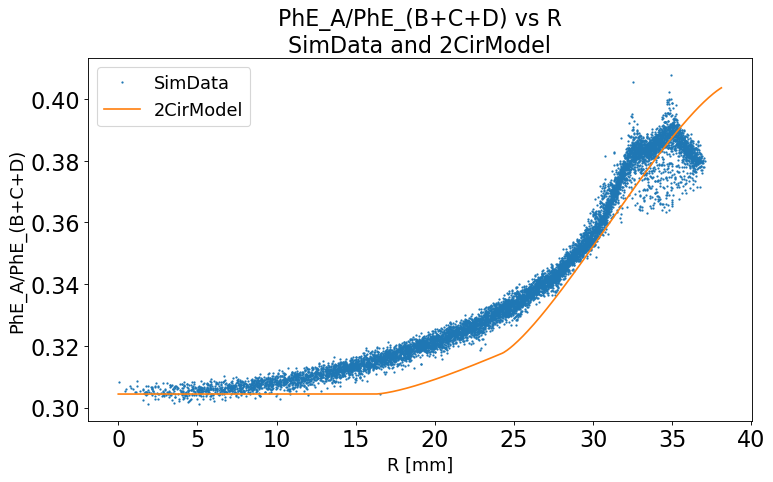

In [42]:
PhE_A2BCD = PhE_A/PhE_BCD
plt.plot(R[cut], PhE_A2BCD[cut], '.',markersize=2,label='SimData')
plt.plot(d,Energy_A/Energy_BCD,label='2CirModel')
#plt.plot(R[~cut],PhE_A2BCD[~cut],'.',label='ColEff<0.98')
#plt.hlines(0.35,0,38.1,linestyles='dashed',colors='g',lw=2,label='A/BCD=0.35')
plt.title('PhE_A/PhE_(B+C+D) vs R'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('PhE_A/PhE_(B+C+D)')
plt.legend()
plt.show()

## 2.3 Three Circles for Fast Component

In [43]:
r1 = 7
r2 = 15
r3 = 25
R1 = 31.3
R2 = 36.1
R3 = 38.1

step = 0.1
d    = np.linspace(0,R3,int(R3/step))

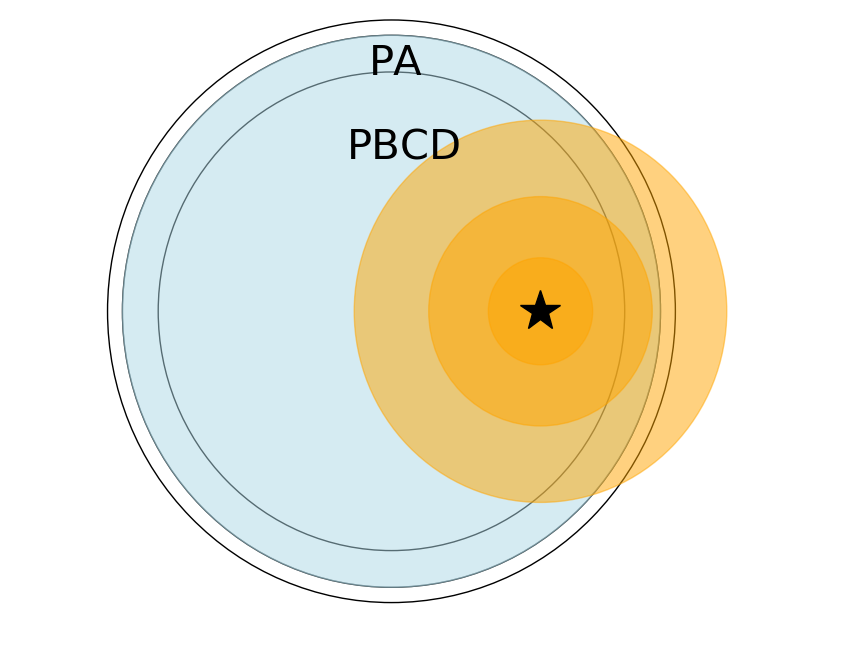

In [44]:
plt.figure(figsize=(10, 8), dpi=100)
Rh = 20
circle_Det   = plt.Circle(( 0, 0), R3, edgecolor='k',fill=False)
circle_PA    = plt.Circle(( 0, 0), R2, edgecolor='k',fill=False)
circle_PBCD  = plt.Circle(( 0, 0), R1, edgecolor='k',fill=False)
circle_slow  = plt.Circle(( 0, 0), R2, color='lightblue', alpha=0.5)
circle_fast1 = plt.Circle((Rh, 0), r1, color='orange', alpha=0.5)
circle_fast2 = plt.Circle((Rh, 0), r2, color='orange', alpha=0.5)
circle_fast3 = plt.Circle((Rh, 0), r3, color='orange', alpha=0.5)
plt.plot(Rh, 0,'*',color='k',markersize=30)
plt.gca().add_patch(circle_Det)
plt.gca().add_patch(circle_PA)
plt.gca().add_patch(circle_PBCD)
plt.gca().add_patch(circle_slow)
plt.gca().add_patch(circle_fast1)
plt.gca().add_patch(circle_fast2)
plt.gca().add_patch(circle_fast3)

plt.text(-3, 31,'PA', fontsize='30')
#plt.text( -1,  31, 'A', size='xx-large')
plt.text(-6, 20,'PBCD', fontsize='30')


plt.xlim(-40-2,40+20+2)
plt.ylim(-40+0.5,40-0.5)
plt.axis('off')
plt.show()

In [45]:
EnergyfastRatio1 = 2.00/100
EnergyfastRatio2 = 2.00/100
EnergyfastRatio3 = 2.00/100
EnergyslowRatio  = 1-EnergyfastRatio1-EnergyfastRatio2-EnergyfastRatio3

In [46]:
pi = np.pi
Area_r1 = pi*r1**2
Area_r2 = pi*r2**2
Area_r3 = pi*r3**2
Area_R1 = pi*R1**2
Area_R2 = pi*R2**2
Area_R3 = pi*R3**2

In [47]:
Area_PT   = pi*R2**2
Area_PA   = pi*R2**2-pi*R1**2
Area_PBCD = pi*R1**2

In [48]:
Area_slowPBCD  = Area_PBCD
Area_slowPA    = Area_PA
Ratio_slowPBCD = Area_PBCD/Area_PT
Ratio_slowPA   = Area_PA/Area_PT

### 2.3.1 Fraction of Phonon Energy BCD

In [49]:
step = 0.1
## overlap r1R1
d1    = np.linspace(R1-r1+step,R3,int((R3-R1+r1)/step))
term1 = (r1**2)*np.arccos((d1**2+r1**2-R1**2)/(2*d1*r1))
term2 = (R1**2)*np.arccos((d1**2-r1**2+R1**2)/(2*d1*R1))
term3 = -0.5*np.sqrt((d1+r1-R1)*(d1-r1+R1)*(-d1+r1+R1)*(d1+r1+R1))
Area_overlap_r1R1  = term1+term2+term3
Area_lune_r1R1     = Area_r1-Area_overlap_r1R1
Ratio_overlap_r1R1 = Area_overlap_r1R1/Area_r1
Ratio_lune_r1R1    = 1-Ratio_overlap_r1R1
Ratio_r1inBCD = np.concatenate((np.ones(len(d)-len(d1)),Ratio_overlap_r1R1),axis=None)

In [50]:
## overlap r2R1
d2    = np.linspace(R1-r2+step,R3,int((R3-R1+r2)/step))
term1 = (r2**2)*np.arccos((d2**2+r2**2-R1**2)/(2*d2*r2))
term2 = (R1**2)*np.arccos((d2**2-r2**2+R1**2)/(2*d2*R1))
term3 = -0.5*np.sqrt((d2+r2-R1)*(d2-r2+R1)*(-d2+r2+R1)*(d2+r2+R1))
Area_overlap_r2R1  = term1+term2+term3
Area_lune_r2R1     = Area_r2-Area_overlap_r2R1
Ratio_overlap_r2R1 = Area_overlap_r2R1/Area_r2
Ratio_lune_r2R1    = 1-Ratio_overlap_r2R1
Ratio_r2inBCD = np.concatenate((np.ones(len(d)-len(d2)),Ratio_overlap_r2R1),axis=None)

In [51]:
## overlap r3R1
d3    = np.linspace(R1-r3+step,R3,int((R3-R1+r3)/step))
term1 = (r3**2)*np.arccos((d3**2+r3**2-R1**2)/(2*d3*r3))
term2 = (R1**2)*np.arccos((d3**2-r3**2+R1**2)/(2*d3*R1))
term3 = -0.5*np.sqrt((d3+r3-R1)*(d3-r3+R1)*(-d3+r3+R1)*(d3+r3+R1))
Area_overlap_r3R1  = term1+term2+term3
Area_lune_r3R1     = Area_r3-Area_overlap_r3R1
Ratio_overlap_r3R1 = Area_overlap_r3R1/Area_r3
Ratio_lune_r3R1    = 1-Ratio_overlap_r3R1
Ratio_r3inBCD = np.concatenate((np.ones(len(d)-len(d3)),Ratio_overlap_r3R1),axis=None)

In [52]:
Energy_BCD = EnergyTotal*( EnergyfastRatio1*Ratio_r1inBCD
                          +EnergyfastRatio2*Ratio_r2inBCD
                          +EnergyfastRatio3*Ratio_r3inBCD
                          +EnergyslowRatio*Ratio_slowPBCD)

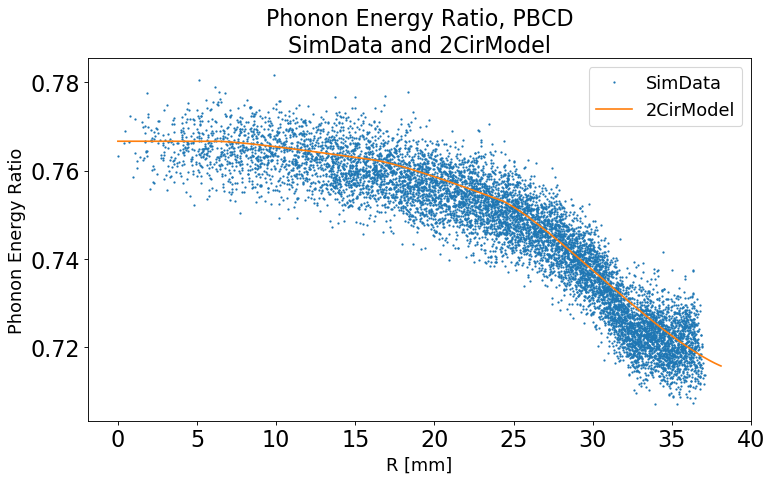

In [53]:
plt.plot(R[cut], PhE_BCD[cut]/EnergyTotal, '.',markersize=2,label='SimData')
plt.plot(d,Energy_BCD/EnergyTotal,label='2CirModel')

plt.title('Phonon Energy Ratio, PBCD'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('Phonon Energy Ratio')
plt.legend()
plt.show()

### 2.3.2 Fraction of Phonon Energy A

In [54]:
step = 0.1
## overlap r1R2
d1    = np.linspace(R2-r1+step,R3,int((R3-R2+r1)/step))
term1 = (r1**2)*np.arccos((d1**2+r1**2-R2**2)/(2*d1*r1))
term2 = (R2**2)*np.arccos((d1**2-r1**2+R2**2)/(2*d1*R2))
term3 = -0.5*np.sqrt((d1+r1-R2)*(d1-r1+R2)*(-d1+r1+R2)*(d1+r1+R2))
Area_overlap_r1R2  = term1+term2+term3
Area_lune_r1R2     = Area_r1-Area_overlap_r1R2
Ratio_overlap_r1R2 = Area_overlap_r1R2/Area_r1
Ratio_lune_r1R2    = 1-Ratio_overlap_r1R2
Ratio_r1inA = 1-Ratio_r1inBCD#-np.concatenate((np.zeros(len(d)-len(d1)),Ratio_lune_r1R2),axis=None)

In [55]:
step = 0.1
## overlap r2R2
d2    = np.linspace(R2-r2+step,R3,int((R3-R2+r2)/step))
term1 = (r2**2)*np.arccos((d2**2+r2**2-R2**2)/(2*d2*r2))
term2 = (R2**2)*np.arccos((d2**2-r2**2+R2**2)/(2*d2*R2))
term3 = -0.5*np.sqrt((d2+r2-R2)*(d2-r2+R2)*(-d2+r2+R2)*(d2+r2+R2))
Area_overlap_r2R2  = term1+term2+term3
Area_lune_r2R2     = Area_r2-Area_overlap_r2R2
Ratio_overlap_r2R2 = Area_overlap_r2R2/Area_r2
Ratio_lune_r2R2    = 1-Ratio_overlap_r2R2
Ratio_r2inA = 1-Ratio_r2inBCD#-np.concatenate((np.zeros(len(d)-len(d2)),Ratio_lune_r2R2),axis=None)

In [56]:
step = 0.1
## overlap r3R2
d3    = np.linspace(R2-r3+step,R3,int((R3-R2+r3)/step))
term1 = (r3**2)*np.arccos((d3**2+r3**2-R2**2)/(2*d3*r3))
term2 = (R2**2)*np.arccos((d3**2-r3**2+R2**2)/(2*d3*R2))
term3 = -0.5*np.sqrt((d3+r3-R2)*(d3-r3+R2)*(-d3+r3+R2)*(d3+r3+R2))
Area_overlap_r3R2  = term1+term2+term3
Area_lune_r3R2     = Area_r3-Area_overlap_r3R2
Ratio_overlap_r3R2 = Area_overlap_r3R2/Area_r3
Ratio_lune_r3R2    = 1-Ratio_overlap_r3R2
Ratio_r3inA = 1-Ratio_r3inBCD#-np.concatenate((np.zeros(len(d)-len(d3)),Ratio_lune_r3R2),axis=None)

In [57]:
Energy_A = EnergyTotal*( EnergyfastRatio1*Ratio_r1inA
                        +EnergyfastRatio2*Ratio_r2inA
                        +EnergyfastRatio3*Ratio_r3inA
                        +EnergyslowRatio*Ratio_slowPA)

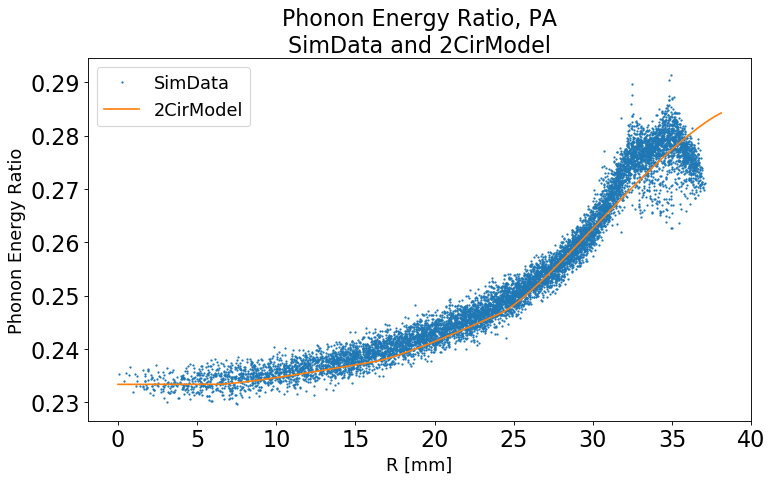

In [58]:
plt.plot(R[cut], PhE_A[cut]/EnergyTotal, '.',markersize=2,label='SimData')
plt.plot(d,Energy_A/EnergyTotal,label='2CirModel')

plt.title('Phonon Energy Ratio, PA'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('Phonon Energy Ratio')
plt.legend()
plt.show()

### 2.3.3 Phonon Energy A2BCD

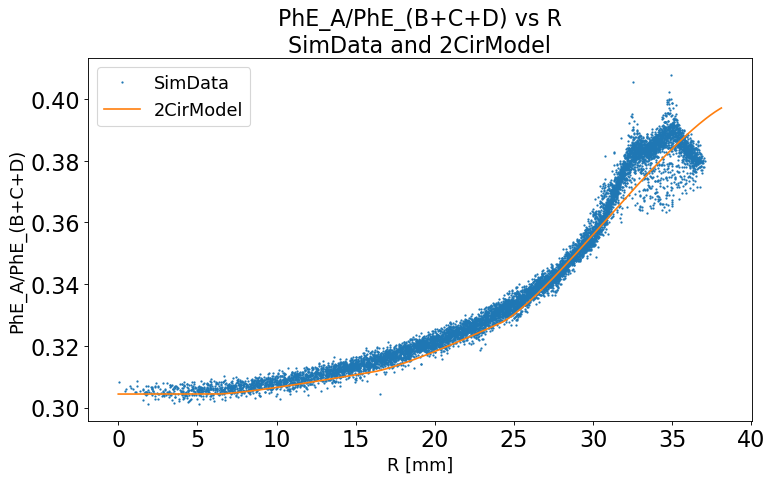

In [59]:
PhE_A2BCD = PhE_A/PhE_BCD
plt.plot(R[cut], PhE_A2BCD[cut], '.',markersize=2,label='SimData')
plt.plot(d,Energy_A/Energy_BCD,label='2CirModel')
#plt.plot(R[~cut],PhE_A2BCD[~cut],'.',label='ColEff<0.98')
#plt.hlines(0.35,0,38.1,linestyles='dashed',colors='g',lw=2,label='A/BCD=0.35')
plt.title('PhE_A/PhE_(B+C+D) vs R'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('PhE_A/PhE_(B+C+D)')
plt.legend()
plt.show()

## 2.4 Four Circles for Fast Component

In [91]:
r1 = 7
r2 = 15
r3 = 22
r4 = 29.9
R1 = 31.3
R2 = 36.1
R3 = 38.1

step = 0.1
d    = np.linspace(0,R3,int(R3/step))

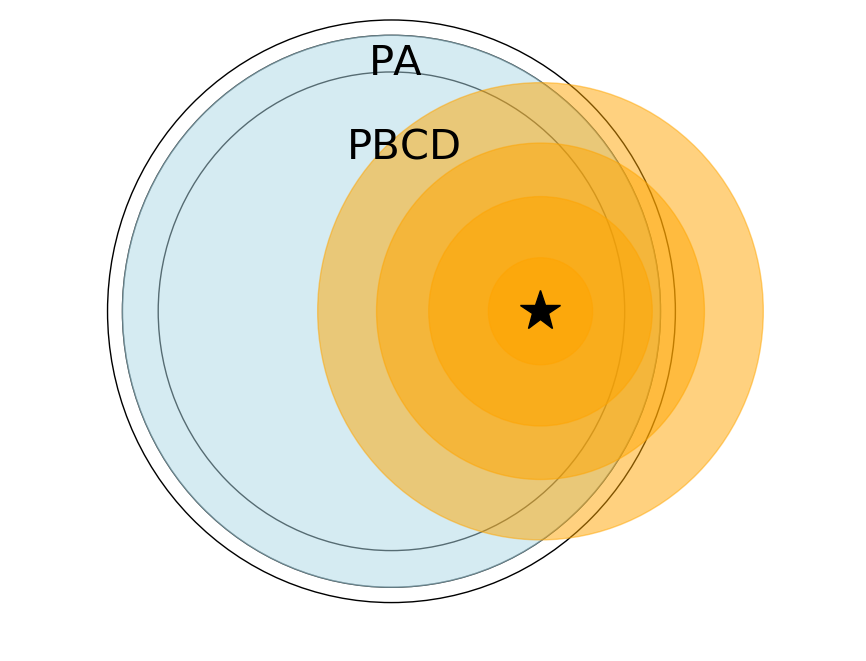

In [92]:
plt.figure(figsize=(10, 8), dpi=100)
Rh = 20
circle_Det   = plt.Circle(( 0, 0), R3, edgecolor='k',fill=False)
circle_PA    = plt.Circle(( 0, 0), R2, edgecolor='k',fill=False)
circle_PBCD  = plt.Circle(( 0, 0), R1, edgecolor='k',fill=False)
circle_slow  = plt.Circle(( 0, 0), R2, color='lightblue', alpha=0.5)
circle_fast1 = plt.Circle((Rh, 0), r1, color='orange', alpha=0.5)
circle_fast2 = plt.Circle((Rh, 0), r2, color='orange', alpha=0.5)
circle_fast3 = plt.Circle((Rh, 0), r3, color='orange', alpha=0.5)
circle_fast4 = plt.Circle((Rh, 0), r4, color='orange', alpha=0.5)
plt.plot(Rh, 0,'*',color='k',markersize=30)
plt.gca().add_patch(circle_Det)
plt.gca().add_patch(circle_PA)
plt.gca().add_patch(circle_PBCD)
plt.gca().add_patch(circle_slow)
plt.gca().add_patch(circle_fast1)
plt.gca().add_patch(circle_fast2)
plt.gca().add_patch(circle_fast3)
plt.gca().add_patch(circle_fast4)

plt.text(-3, 31,'PA', fontsize='30')
#plt.text( -1,  31, 'A', size='xx-large')
plt.text(-6, 20,'PBCD', fontsize='30')


plt.xlim(-40-2,40+20+2)
plt.ylim(-40+0.5,40-0.5)
plt.axis('off')
plt.show()

In [93]:
EnergyfastRatio1 = 1.50/100
EnergyfastRatio2 = 1.50/100
EnergyfastRatio3 = 1.50/100
EnergyfastRatio4 = 1.50/100
EnergyslowRatio  = 1-EnergyfastRatio1-EnergyfastRatio2-EnergyfastRatio3-EnergyfastRatio4

In [94]:
pi = np.pi
Area_r1 = pi*r1**2
Area_r2 = pi*r2**2
Area_r3 = pi*r3**2
Area_r4 = pi*r4**2
Area_R1 = pi*R1**2
Area_R2 = pi*R2**2
Area_R3 = pi*R3**2

In [95]:
Area_PT   = pi*R2**2
Area_PA   = pi*R2**2-pi*R1**2
Area_PBCD = pi*R1**2

In [96]:
Area_slowPBCD  = Area_PBCD
Area_slowPA    = Area_PA
Ratio_slowPBCD = Area_PBCD/Area_PT
Ratio_slowPA   = Area_PA/Area_PT

### 2.4.1 Fraction of Phonon Energy BCD

In [97]:
step = 0.1
## overlap r1R1
d1    = np.linspace(R1-r1+step,R3,int((R3-R1+r1)/step))
term1 = (r1**2)*np.arccos((d1**2+r1**2-R1**2)/(2*d1*r1))
term2 = (R1**2)*np.arccos((d1**2-r1**2+R1**2)/(2*d1*R1))
term3 = -0.5*np.sqrt((d1+r1-R1)*(d1-r1+R1)*(-d1+r1+R1)*(d1+r1+R1))
Area_overlap_r1R1  = term1+term2+term3
Area_lune_r1R1     = Area_r1-Area_overlap_r1R1
Ratio_overlap_r1R1 = Area_overlap_r1R1/Area_r1
Ratio_lune_r1R1    = 1-Ratio_overlap_r1R1
Ratio_r1inBCD = np.concatenate((np.ones(len(d)-len(d1)),Ratio_overlap_r1R1),axis=None)

In [98]:
## overlap r2R1
d2    = np.linspace(R1-r2+step,R3,int((R3-R1+r2)/step))
term1 = (r2**2)*np.arccos((d2**2+r2**2-R1**2)/(2*d2*r2))
term2 = (R1**2)*np.arccos((d2**2-r2**2+R1**2)/(2*d2*R1))
term3 = -0.5*np.sqrt((d2+r2-R1)*(d2-r2+R1)*(-d2+r2+R1)*(d2+r2+R1))
Area_overlap_r2R1  = term1+term2+term3
Area_lune_r2R1     = Area_r2-Area_overlap_r2R1
Ratio_overlap_r2R1 = Area_overlap_r2R1/Area_r2
Ratio_lune_r2R1    = 1-Ratio_overlap_r2R1
Ratio_r2inBCD = np.concatenate((np.ones(len(d)-len(d2)),Ratio_overlap_r2R1),axis=None)

In [99]:
## overlap r3R1
d3    = np.linspace(R1-r3+step,R3,int((R3-R1+r3)/step))
term1 = (r3**2)*np.arccos((d3**2+r3**2-R1**2)/(2*d3*r3))
term2 = (R1**2)*np.arccos((d3**2-r3**2+R1**2)/(2*d3*R1))
term3 = -0.5*np.sqrt((d3+r3-R1)*(d3-r3+R1)*(-d3+r3+R1)*(d3+r3+R1))
Area_overlap_r3R1  = term1+term2+term3
Area_lune_r3R1     = Area_r3-Area_overlap_r3R1
Ratio_overlap_r3R1 = Area_overlap_r3R1/Area_r3
Ratio_lune_r3R1    = 1-Ratio_overlap_r3R1
Ratio_r3inBCD = np.concatenate((np.ones(len(d)-len(d3)),Ratio_overlap_r3R1),axis=None)

In [100]:
d4    = np.linspace(R1-r4+step,R3,int((R3-R1+r4)/step))
term1 = (r4**2)*np.arccos((d4**2+r4**2-R1**2)/(2*d4*r4))
term2 = (R1**2)*np.arccos((d4**2-r4**2+R1**2)/(2*d4*R1))
term3 = -0.5*np.sqrt((d4+r4-R1)*(d4-r4+R1)*(-d4+r4+R1)*(d4+r4+R1))
Area_overlap_r4R1  = term1+term2+term3
Area_lune_r4R1     = Area_r4-Area_overlap_r4R1
Ratio_overlap_r4R1 = Area_overlap_r4R1/Area_r4
Ratio_lune_r4R1    = 1-Ratio_overlap_r4R1
Ratio_r4inBCD = np.concatenate((np.ones(len(d)-len(d4)),Ratio_overlap_r4R1),axis=None)

In [101]:
Energy_BCD = EnergyTotal*( EnergyfastRatio1*Ratio_r1inBCD
                          +EnergyfastRatio2*Ratio_r2inBCD
                          +EnergyfastRatio3*Ratio_r3inBCD
                          +EnergyfastRatio3*Ratio_r4inBCD
                          +EnergyslowRatio*Ratio_slowPBCD)

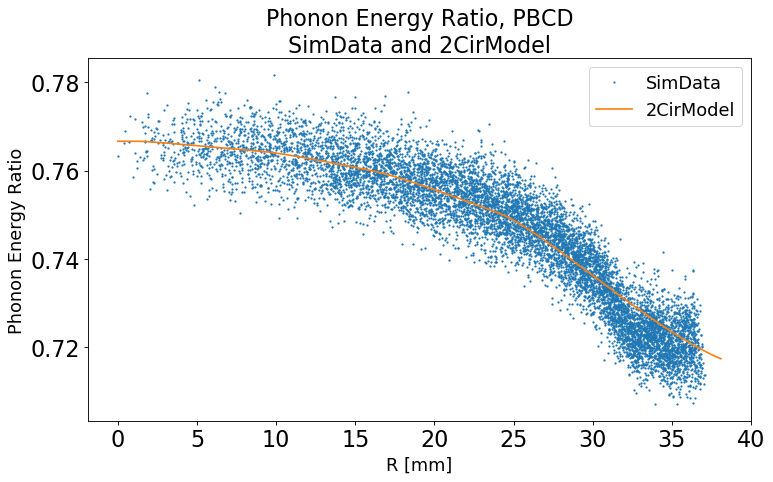

In [102]:
plt.plot(R[cut], PhE_BCD[cut]/EnergyTotal, '.',markersize=2,label='SimData')
plt.plot(d,Energy_BCD/EnergyTotal,label='2CirModel')
plt.title('Phonon Energy Ratio, PBCD'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('Phonon Energy Ratio')
plt.legend()
plt.show()

### 2.3.2 Fraction of Phonon Energy A

In [103]:
step = 0.1
## overlap r1R2
d1    = np.linspace(R2-r1+step,R3,int((R3-R2+r1)/step))
term1 = (r1**2)*np.arccos((d1**2+r1**2-R2**2)/(2*d1*r1))
term2 = (R2**2)*np.arccos((d1**2-r1**2+R2**2)/(2*d1*R2))
term3 = -0.5*np.sqrt((d1+r1-R2)*(d1-r1+R2)*(-d1+r1+R2)*(d1+r1+R2))
Area_overlap_r1R2  = term1+term2+term3
Area_lune_r1R2     = Area_r1-Area_overlap_r1R2
Ratio_overlap_r1R2 = Area_overlap_r1R2/Area_r1
Ratio_lune_r1R2    = 1-Ratio_overlap_r1R2
Ratio_r1inA = 1-Ratio_r1inBCD#-np.concatenate((np.zeros(len(d)-len(d1)),Ratio_lune_r1R2),axis=None)

In [104]:
step = 0.1
## overlap r2R2
d2    = np.linspace(R2-r2+step,R3,int((R3-R2+r2)/step))
term1 = (r2**2)*np.arccos((d2**2+r2**2-R2**2)/(2*d2*r2))
term2 = (R2**2)*np.arccos((d2**2-r2**2+R2**2)/(2*d2*R2))
term3 = -0.5*np.sqrt((d2+r2-R2)*(d2-r2+R2)*(-d2+r2+R2)*(d2+r2+R2))
Area_overlap_r2R2  = term1+term2+term3
Area_lune_r2R2     = Area_r2-Area_overlap_r2R2
Ratio_overlap_r2R2 = Area_overlap_r2R2/Area_r2
Ratio_lune_r2R2    = 1-Ratio_overlap_r2R2
Ratio_r2inA = 1-Ratio_r2inBCD#-np.concatenate((np.zeros(len(d)-len(d2)),Ratio_lune_r2R2),axis=None)

In [105]:
step = 0.1
## overlap r3R2
d3    = np.linspace(R2-r3+step,R3,int((R3-R2+r3)/step))
term1 = (r3**2)*np.arccos((d3**2+r3**2-R2**2)/(2*d3*r3))
term2 = (R2**2)*np.arccos((d3**2-r3**2+R2**2)/(2*d3*R2))
term3 = -0.5*np.sqrt((d3+r3-R2)*(d3-r3+R2)*(-d3+r3+R2)*(d3+r3+R2))
Area_overlap_r3R2  = term1+term2+term3
Area_lune_r3R2     = Area_r3-Area_overlap_r3R2
Ratio_overlap_r3R2 = Area_overlap_r3R2/Area_r3
Ratio_lune_r3R2    = 1-Ratio_overlap_r3R2
Ratio_r3inA = 1-Ratio_r3inBCD#-np.concatenate((np.zeros(len(d)-len(d3)),Ratio_lune_r3R2),axis=None)

In [106]:
step = 0.1
## overlap r4R2
d4    = np.linspace(R2-r4+step,R3,int((R3-R2+r4)/step))
term1 = (r4**2)*np.arccos((d4**2+r4**2-R2**2)/(2*d4*r4))
term2 = (R2**2)*np.arccos((d4**2-r4**2+R2**2)/(2*d4*R2))
term3 = -0.5*np.sqrt((d4+r4-R2)*(d4-r4+R2)*(-d4+r4+R2)*(d4+r4+R2))
Area_overlap_r4R2  = term1+term2+term3
Area_lune_r4R2     = Area_r4-Area_overlap_r4R2
Ratio_overlap_r4R2 = Area_overlap_r4R2/Area_r4
Ratio_lune_r4R2    = 1-Ratio_overlap_r4R2
Ratio_r4inA = 1-Ratio_r4inBCD#-np.concatenate((np.zeros(len(d)-len(d4)),Ratio_lune_r4R2),axis=None)

In [107]:
Energy_A = EnergyTotal*( EnergyfastRatio1*Ratio_r1inA
                        +EnergyfastRatio2*Ratio_r2inA
                        +EnergyfastRatio3*Ratio_r3inA
                        +EnergyfastRatio4*Ratio_r4inA
                        +EnergyslowRatio*Ratio_slowPA)

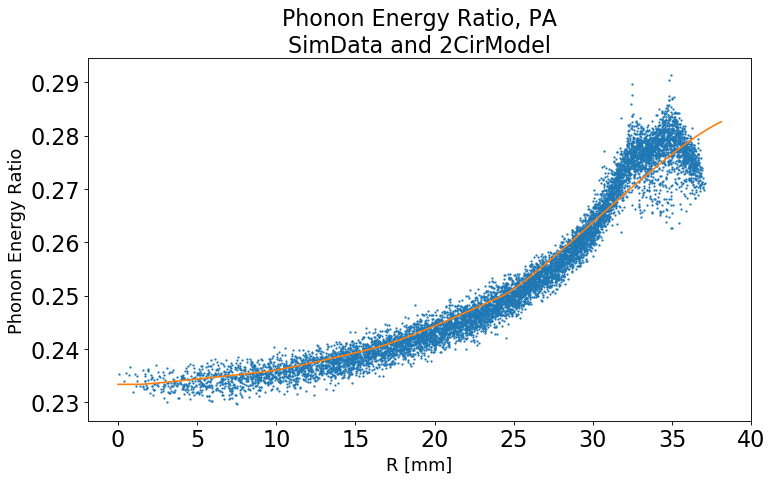

In [108]:
plt.plot(R[cut], PhE_A[cut]/EnergyTotal, '.',markersize=2,label='SimData')
plt.plot(d,Energy_A/EnergyTotal,label='2CirModel')
plt.title('Phonon Energy Ratio, PA'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('Phonon Energy Ratio')
plt.show()

### 2.3.3 Phonon Energy A2BCD

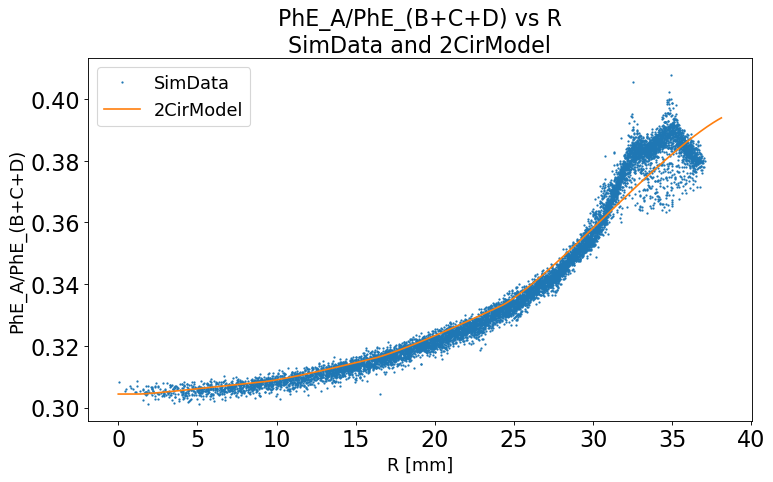

In [109]:
PhE_A2BCD = PhE_A/PhE_BCD
plt.plot(R[cut], PhE_A2BCD[cut], '.',markersize=2,label='SimData')
plt.plot(d,Energy_A/Energy_BCD,label='2CirModel')
#plt.plot(R[~cut],PhE_A2BCD[~cut],'.',label='ColEff<0.98')
#plt.hlines(0.35,0,38.1,linestyles='dashed',colors='g',lw=2,label='A/BCD=0.35')
plt.title('PhE_A/PhE_(B+C+D) vs R'+'\nSimData and 2CirModel')
plt.xlabel('R [mm]')
plt.ylabel('PhE_A/PhE_(B+C+D)')
plt.legend()
plt.show()